In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Subcutaneus adipose tissue
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Adipose tissue data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Creating folder for outputs
os.makedirs('../Khawaja_et_al_outputs/Adipose')

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/subc_adipose_tissue.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [5]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]
3755it [00:12, 290.85it/s]


In [6]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000805_B008544_S10.mm10-plus-3-0,Multiple,18m,A10_B000805,nan,facs,18_46_F,3060,6829.702148,2,7,...,NCBITaxon:10090,T cell,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117233
A12_B000805_B008544_S12.mm10-plus-3-0,Multiple,18m,A12_B000805,nan,facs,18_46_F,1493,4220.322754,2,15,...,NCBITaxon:10090,natural killer cell,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.108063
A13_B000805_B008544_S13.mm10-plus-3-0,Multiple,18m,A13_B000805,nan,facs,18_46_F,3374,4893.486816,5,3,...,NCBITaxon:10090,myeloid cell,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.374733
A14_B000805_B008544_S14.mm10-plus-3-0,Multiple,18m,A14_B000805,nan,facs,18_46_F,3492,4275.080566,10,3,...,NCBITaxon:10090,myeloid cell,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117207
A15_B000805_B008544_S15.mm10-plus-3-0,Multiple,18m,A15_B000805,nan,facs,18_46_F,1394,3861.068848,2,7,...,NCBITaxon:10090,"CD8-positive, alpha-beta T cell",Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.231930


## CMA net score/cell type (fold over whole tissue)

In [7]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_46_F', '18_53_M', '18_47_F', '18_45_M', '24_60_M', '24_59_M', '24_58_M', '24_61_M', '3_38_F', '3_56_F', '3_8_M', '3_9_M', '3_39_F', '3_10_M', '3_11_M']


**Mice n for Liver**
    - Young females: 3
    - Young males: 4
    - Old females: 2
    - Old males: 6

In [8]:
print(list(barcode.cell_type.unique()))

['T cell', 'natural killer cell', 'myeloid cell', 'CD8-positive, alpha-beta T cell', 'endothelial cell', 'mesenchymal stem cell of adipose', 'B cell', 'CD4-positive, alpha-beta T cell', 'epithelial cell']


In [10]:
# Generating new ages
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    else:                
        barcode.loc[j, 'new_age'] = '18-24m'
        
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'mesenchymal stem cell of adipose':        
        barcode.loc[j, 'new_cell'] = 'Subcut. Adipose MSC'
    
    else:                
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']


barcode.head()

100%|████████████████████████████████████████████████████████████████████████████| 3755/3755 [00:00<00:00, 5264.97it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell
index,,,,,,,,,,,,,,,,,,,,,
A10_B000805_B008544_S10.mm10-plus-3-0,Multiple,18m,A10_B000805,nan,facs,18_46_F,3060,6829.702148,2,7,...,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117233,18-24m,T cell
A12_B000805_B008544_S12.mm10-plus-3-0,Multiple,18m,A12_B000805,nan,facs,18_46_F,1493,4220.322754,2,15,...,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.108063,18-24m,natural killer cell
A13_B000805_B008544_S13.mm10-plus-3-0,Multiple,18m,A13_B000805,nan,facs,18_46_F,3374,4893.486816,5,3,...,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.374733,18-24m,myeloid cell
A14_B000805_B008544_S14.mm10-plus-3-0,Multiple,18m,A14_B000805,nan,facs,18_46_F,3492,4275.080566,10,3,...,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117207,18-24m,myeloid cell
A15_B000805_B008544_S15.mm10-plus-3-0,Multiple,18m,A15_B000805,nan,facs,18_46_F,1394,3861.068848,2,7,...,Smart-seq2,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.231930,18-24m,"CD8-positive, alpha-beta T cell"


In [4]:
cells = ['Subcut. Adipose MSC']

In [13]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000805_B008544_S10.mm10-plus-3-0,Multiple,18m,A10_B000805,nan,facs,18_46_F,3060,6829.702148,2,7,...,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117233,18-24m,T cell,0.084023
A12_B000805_B008544_S12.mm10-plus-3-0,Multiple,18m,A12_B000805,nan,facs,18_46_F,1493,4220.322754,2,15,...,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.108063,18-24m,natural killer cell,-0.141272
A13_B000805_B008544_S13.mm10-plus-3-0,Multiple,18m,A13_B000805,nan,facs,18_46_F,3374,4893.486816,5,3,...,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.374733,18-24m,myeloid cell,0.341523
A14_B000805_B008544_S14.mm10-plus-3-0,Multiple,18m,A14_B000805,nan,facs,18_46_F,3492,4275.080566,10,3,...,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117207,18-24m,myeloid cell,0.083997
A15_B000805_B008544_S15.mm10-plus-3-0,Multiple,18m,A15_B000805,nan,facs,18_46_F,1394,3861.068848,2,7,...,normal,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.231930,18-24m,"CD8-positive, alpha-beta T cell",-0.265140


### Cell types stats

In [14]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['new_cell']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [15]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,Subcut. Adipose MSC,3m,737,20.260075,0.000040,Not normal
1,Subcut. Adipose MSC,18-24m,833,20.420432,0.000037,Not normal


In [16]:
# Calculating MWU test (for not normal distributions) for the cells of interest
for i in cells:
    group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Subcut. Adipose Msc statistics
MWU test pval = 0.00802910128257859




C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2055212890.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.new_cell==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2055212890.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.new_cell==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\1544519504.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.new_cell ==cells[0]][barcode.new_age=='18-24m']['net_score']) -(0.005)


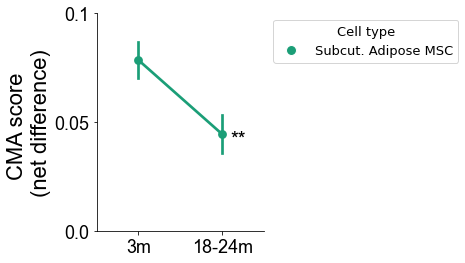

In [24]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='new_cell', order=["3m", "18-24m"], 
              hue_order=cells, palette="Dark2", ci=68)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(0.0, 0.10) 
ax.set_yticks([0.0, 0.05, 0.10])
ax.set_yticklabels([0.0, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#1b9e77', label='Subcut. Adipose MSC', 
                         markersize=10)]

plt.legend(handles=legend_elements, bbox_to_anchor = (2.2, 1), facecolor='white', title="Cell type", title_fontsize = "13", 
           fontsize=13)
                          
# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.new_cell ==cells[0]][barcode.new_age=='18-24m']['net_score']) -(0.005)
plt.text(x1, y1, "**", fontsize=20, **hfont)

plt.savefig('../Khawaja_et_al_outputs/Adipose/SAd_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [25]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\1532967860.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\1532967860.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\1532967860.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['new_cell']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,Subcut. Adipose MSC,3m,737,0.078538,0.008096
1,Subcut. Adipose MSC,18-24m,833,0.044473,0.008761


In [26]:
df_raw.to_excel('../Khawaja_et_al_outputs/Adipose/Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex  (fold over whole tissue)

### Stats

In [27]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["new_cell"]==i].index)))
    print(barcode[barcode["new_cell"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Subcut. Adipose Msc length:1570
sex     new_age
male    18-24m     615
        3m         378
female  3m         359
        18-24m     218
dtype: int64




In [28]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['new_cell']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Subcut. Adipose Msc 2-way Anova

                       df     sum_sq   mean_sq          F        PR(>F)
C(new_age)            1.0   0.453744  0.453744   8.297509  4.023978e-03
C(sex)                1.0   1.609387  1.609387  29.430461  6.705371e-08
C(new_age):C(sex)     1.0   1.506745  1.506745  27.553478  1.737455e-07
Residual           1566.0  85.635747  0.054684        NaN           NaN


Subcut. Adipose Msc Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  0.1196 0.9049       1.0  False
18-24m & female   3m & female  1.6899 0.0916    0.5495  False
18-24m & female     3m & male -5.5769    0.0       0.0   True
  18-24m & male   3m & female  1.9173 0.0555     0.333  False
  18-24m & male     3m & male -6.4686    0.0       0.0   True
    3m & female     3m & male -8.4013

### Graphs

#### MS cells of adipose tissue

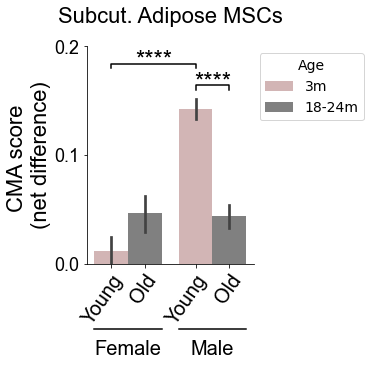

In [46]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.new_cell==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0.0, 0.20)
ax.set_yticks([0.0, 0.10, 0.20])
ax.set_yticklabels([0.0, 0.10, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Subcut. Adipose MSCs', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.16 , 0.004, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, .8   
y, h, col = 0.18 , 0.004, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khawaja_et_al_outputs/Adipose/SAd_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [38]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [39]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\1738379689.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\1738379689.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\1738379689.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,Subcut. Adipose MSC,3m,female,359,0.011825,0.012569
1,Subcut. Adipose MSC,3m,male,378,0.141897,0.009228
2,Subcut. Adipose MSC,18-24m,female,218,0.046234,0.015946
3,Subcut. Adipose MSC,18-24m,male,615,0.043849,0.010441


## CMA net score/cell type & sex (fold over each cell type young)

In [40]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
 11%|█████████▎                                                                          | 1/9 [00:00<00:00,  9.77it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2122786486.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.25it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,n_genes,n_counts,louvain,leiden,...,organism,sex,tissue,ethnicity,development_stage,score,new_age,new_cell,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000805_B008544_S10.mm10-plus-3-0,Multiple,18m,A10_B000805,nan,facs,18_46_F,3060,6829.702148,2,7,...,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117233,18-24m,T cell,0.084023,0.157865
A12_B000805_B008544_S12.mm10-plus-3-0,Multiple,18m,A12_B000805,nan,facs,18_46_F,1493,4220.322754,2,15,...,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.108063,18-24m,natural killer cell,-0.141272,0.012572
A13_B000805_B008544_S13.mm10-plus-3-0,Multiple,18m,A13_B000805,nan,facs,18_46_F,3374,4893.486816,5,3,...,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.374733,18-24m,myeloid cell,0.341523,0.383255
A14_B000805_B008544_S14.mm10-plus-3-0,Multiple,18m,A14_B000805,nan,facs,18_46_F,3492,4275.080566,10,3,...,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,0.117207,18-24m,myeloid cell,0.083997,0.125729
A15_B000805_B008544_S15.mm10-plus-3-0,Multiple,18m,A15_B000805,nan,facs,18_46_F,1394,3861.068848,2,7,...,Mus musculus,female,subcutaneous adipose tissue,na,18 month-old stage,-0.231930,18-24m,"CD8-positive, alpha-beta T cell",-0.265140,-0.231751


### Graphs

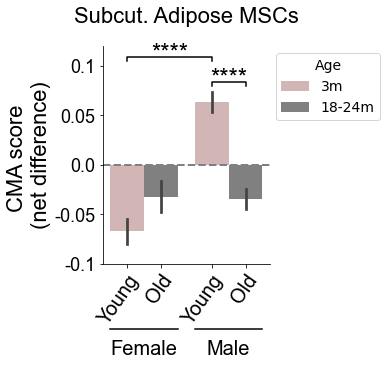

In [47]:
# Figure MSCs
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.12)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Subcut. Adipose MSCs', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.08 , 0.004, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, .8   
y, h, col = 0.105 , 0.004, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig('../Khawaja_et_al_outputs/Adipose/SAd_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [48]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [49]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2323915190.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2323915190.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2323915190.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,Subcut. Adipose MSC,3m,female,359,-0.066713,0.012569
1,Subcut. Adipose MSC,3m,male,378,0.063359,0.009228
2,Subcut. Adipose MSC,18-24m,female,218,-0.032304,0.015946
3,Subcut. Adipose MSC,18-24m,male,615,-0.034688,0.010441


## CMA network heatmaps by cell type & sex

In [50]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

In [53]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:3]+'_heat', index=True)
        
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop, fontdict={'family':'Arial', 'size': 22}, y=1.05)

    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig('../Khawaja_et_al_outputs/Adipose/{}_heat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2352352696.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2352352696.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2352352696.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_9284\2352352696.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['new_cell'] == cellp

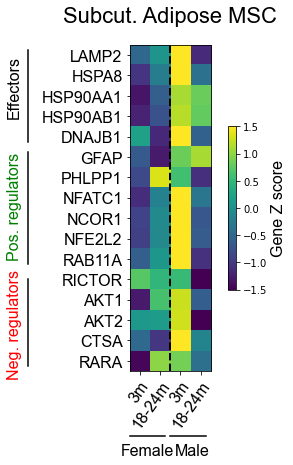

In [54]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [3]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [5]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A10_B000805_B008544_S10.mm10-plus-3-0,A10_B000805,T cell,female,18m,-1.335284,-2.162588
1,A12_B000805_B008544_S12.mm10-plus-3-0,A12_B000805,natural killer cell,female,18m,-1.335284,-2.162588
2,A13_B000805_B008544_S13.mm10-plus-3-0,A13_B000805,myeloid cell,female,18m,0.734370,0.458787
3,A14_B000805_B008544_S14.mm10-plus-3-0,A14_B000805,myeloid cell,female,18m,1.011691,0.516613
4,A15_B000805_B008544_S15.mm10-plus-3-0,A15_B000805,"CD8-positive, alpha-beta T cell",female,18m,-1.335284,-2.162588


In [6]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    else:                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

# Generating new cell types combining some of them
for j in tqdm(barcode_lys.index):    
    if barcode_lys.loc[j, 'cell_type'] == 'mesenchymal stem cell of adipose':        
        barcode_lys.loc[j, 'new_cell'] = 'Subcut. Adipose MSC'
    
    else:                
        barcode_lys.loc[j, 'new_cell'] = barcode_lys.loc[j, 'cell_type']
     
barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████| 3755/3755 [00:00<00:00, 6481.22it/s]


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
0,A10_B000805_B008544_S10.mm10-plus-3-0,A10_B000805,T cell,female,18m,-1.335284,-2.162588,18-24m,T cell
1,A12_B000805_B008544_S12.mm10-plus-3-0,A12_B000805,natural killer cell,female,18m,-1.335284,-2.162588,18-24m,natural killer cell
2,A13_B000805_B008544_S13.mm10-plus-3-0,A13_B000805,myeloid cell,female,18m,0.734370,0.458787,18-24m,myeloid cell
3,A14_B000805_B008544_S14.mm10-plus-3-0,A14_B000805,myeloid cell,female,18m,1.011691,0.516613,18-24m,myeloid cell
4,A15_B000805_B008544_S15.mm10-plus-3-0,A15_B000805,"CD8-positive, alpha-beta T cell",female,18m,-1.335284,-2.162588,18-24m,"CD8-positive, alpha-beta T cell"


In [7]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[barcode_lys['new_cell'].isin(cells)]
print(barcode_lys.new_cell.unique())
barcode_lys.head()

['Subcut. Adipose MSC']


,index,cell,cell_type,sex,age,L2,L1,new_age,new_cell
7,A2_B000805_B008544_S2.mm10-plus-3-0,A2_B000805,mesenchymal stem cell of adipose,female,18m,0.723593,0.640169,18-24m,Subcut. Adipose MSC
8,A5_B000805_B008544_S5.mm10-plus-3-0,A5_B000805,mesenchymal stem cell of adipose,female,18m,0.773180,0.581811,18-24m,Subcut. Adipose MSC
16,B1_B000805_B008544_S25.mm10-plus-3-0,B1_B000805,mesenchymal stem cell of adipose,female,18m,-1.335284,-2.162588,18-24m,Subcut. Adipose MSC
18,B5_B000805_B008544_S29.mm10-plus-3-0,B5_B000805,mesenchymal stem cell of adipose,female,18m,0.452686,0.371555,18-24m,Subcut. Adipose MSC
19,B6_B000805_B008544_S30.mm10-plus-3-0,B6_B000805,mesenchymal stem cell of adipose,female,18m,0.462784,0.432397,18-24m,Subcut. Adipose MSC


### Graphs

#### Lamp2 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

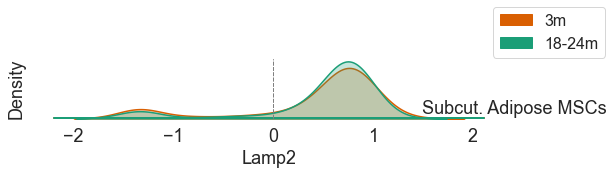

In [82]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=1.5, y=0.1, s='Subcut. Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/SAdL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

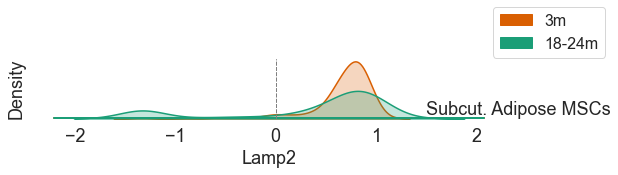

In [85]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=1.5, y=0.15, s='Subcut. Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/SAdL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

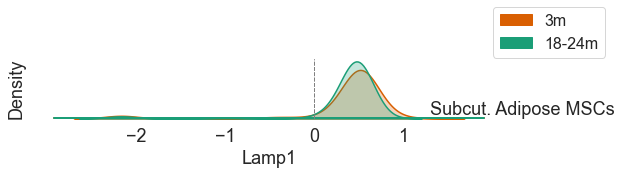

In [89]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=1.3, y=0.15, s='Subcut. Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/SAdL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layo

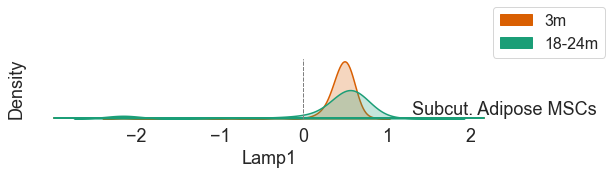

In [92]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='new_cell', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=1.3, y=0.18, s='Subcut. Adipose MSCs', fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 2), facecolor='white', fontsize=16)

plt.savefig('../Khawaja_et_al_outputs/Adipose/SAdL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [8]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['new_cell']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Subcut. Adipose Msc 2-way Anova

                       df      sum_sq    mean_sq          F        PR(>F)
C(new_age)            1.0   10.924149  10.924149  23.989826  1.068636e-06
C(sex)                1.0    1.420592   1.420592   3.119671  7.754722e-02
C(new_age):C(sex)     1.0   12.911119  12.911119  28.353284  1.157603e-07
Residual           1566.0  713.103035   0.455366        NaN           NaN


Subcut. Adipose Msc Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  2.3457 0.0192    0.1154  False
18-24m & female   3m & female  1.0927  0.275       1.0  False
18-24m & female     3m & male -4.7175    0.0       0.0   True
  18-24m & male   3m & female -1.5208 0.1286    0.7718  False
  18-24m & male     3m & male -7.3827    0.0       0.0   True
    3m & female     3m & ma

### Graphs

In [101]:
sns.reset_defaults()

#### Subcut. Adipose MSCs

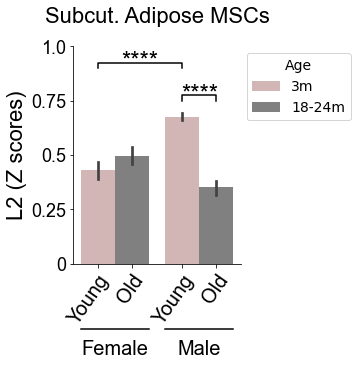

In [16]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.new_cell==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 1)
ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax.set_yticklabels([0, 0.25, 0.50, 0.75, 1.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Subcut. Adipose MSCs', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.75 , 0.025, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, .8   
y, h, col = 0.9 , 0.025, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khawaja_et_al_outputs/Adipose/SAd_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [17]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khawaja_et_al_outputs/Adipose/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [18]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_2692\3361628089.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_2692\3361628089.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_2692\3361628089.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['new_cell']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,Subcut. Adipose MSC,3m,female,359,0.431104,0.037608
1,Subcut. Adipose MSC,3m,male,378,0.676112,0.015923
2,Subcut. Adipose MSC,18-24m,female,218,0.494999,0.042369
3,Subcut. Adipose MSC,18-24m,male,615,0.352271,0.032962
